## <h2 align=center> Ré-implémentation de la fonction GridSearchCV de la librairie scikit-learn pour la prédiction de la qualité du vin</h2>

<h3 align=center>CentraleSupélec-OpenClassrooms Certifiyng Training</h3>

<h3 align=center>Jean Martial Tagro </h3>

Il s'agit d'une ré-implémentation de la fonction de validation croisée de la libraire scikit-learn (la fonction GridSearchCV), dans l’objectif d’effectuer la classification du dataset sur la qualité du vin.<br>
<strong>Attentes :</strong>
L’algorithme devra permettre d’optimiser l’accuracy du modèle. La fonction prendra en entrée le tableau des hyperparamètres à tester ainsi que le nombre de folds. On utilisera des folds exacts (non randomisé) afin de pouvoir comparer les résultats.

Il s'agira ensuite de comparer les performances de mon implémentation par rapport à l’implémentation scikit-learn effectuée lors du TP. Pour cela, le professeur, <b>Chloé-Agathe Azencott</b> (Chargée de recherche au CBIO de MINES ParisTech & Institut Curie. Enseignante à CentraleSupélec - Machine learning & bioinformatique), conseille dans un premier temps de ne pas randomiser la sélection des sets, mais de faire une sélection exacte afin de pouvoir comparer des résultats qui doivent être identiques entre votre implémentation et celle de scikit.

In [13]:
import pandas as pd
from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold # pour faire la stratification

In [15]:
# equiv import numpy et matplotlib
%pylab inline 

Populating the interactive namespace from numpy and matplotlib


### 1. Obtention du dataset

In [16]:
data = pd.read_csv('winequality-white.csv', sep=";")

In [17]:
print(data.columns)

Index(['fixed acidity', 'volatile acidity', 'citric acid', 'residual sugar',
       'chlorides', 'free sulfur dioxide', 'total sulfur dioxide', 'density',
       'pH', 'sulphates', 'alcohol', 'quality'],
      dtype='object')


In [18]:
data.head()

,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [19]:
# Extraction en 2 arrays numpy les points et étiquettes
X = data[data.columns[:-1]].values
y = data['quality'].values

### Observation de la distribution des 11 variables

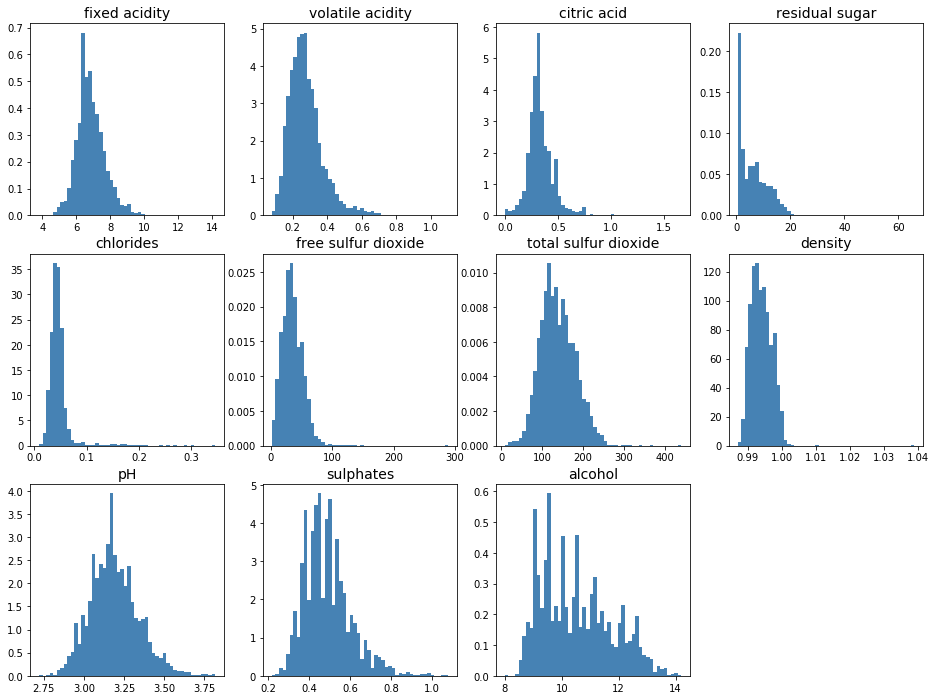

In [20]:
# Representation
fig = plt.figure(figsize=(16,12))

for feat_idx in range(X.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

On remarque en particulier que ces variables prennent des valeurs dans des ensembles différents. Par exemple, “sulphates” varie de 0 à 1 tandis que “total sulfur dioxide” varie de 0 à 440. Il va donc nous falloir <b>standardiser</b> les données pour que la deuxième ne domine pas complètement la première.

### 2. Sélection de modèle

#### 2.1 Transformation du problème en problème de classification

In [21]:
# On crée 2 classes : quality < 6 (pas terrible) / quality > 6 (bon vin)
y_class = np.where(y<6, 0, 1)

#### 2.2. Training/test split : <br><br><font color="red">Il s'agit dans un 1er temps de ne pas ramdomiser la selection des sets pour pouvoir bien comparer les résultats</font>

In [32]:
# On fait une sélection fixe des sets (non randomisée avec random_state=0).

X_train, X_test, y_train, y_test = model_selection.train_test_split(X, y_class, train_size=0.7, random_state=0)

# Check
print(y.shape)
print(y_train.shape)
print(y_test.shape)

(4898,)
(3428,)
(1470,)


Il est important de souligner que la fonction train_test_split fait par défaut une stratification

#### 2.3 Standardisation des features 
##### Attention : on ne va évidemment pas standardiser  les étiquettes

In [33]:
from sklearn import preprocessing

#On standardise les données d’entraînement
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)

#et appliquer la même transformation aux données de test
X_test_std = std_scale.transform(X_test)

On peut visualiser de nouveau les données pour vérifier que les différentes variables prennent des valeurs qui ont maintenant des ordres de grandewur similaires.

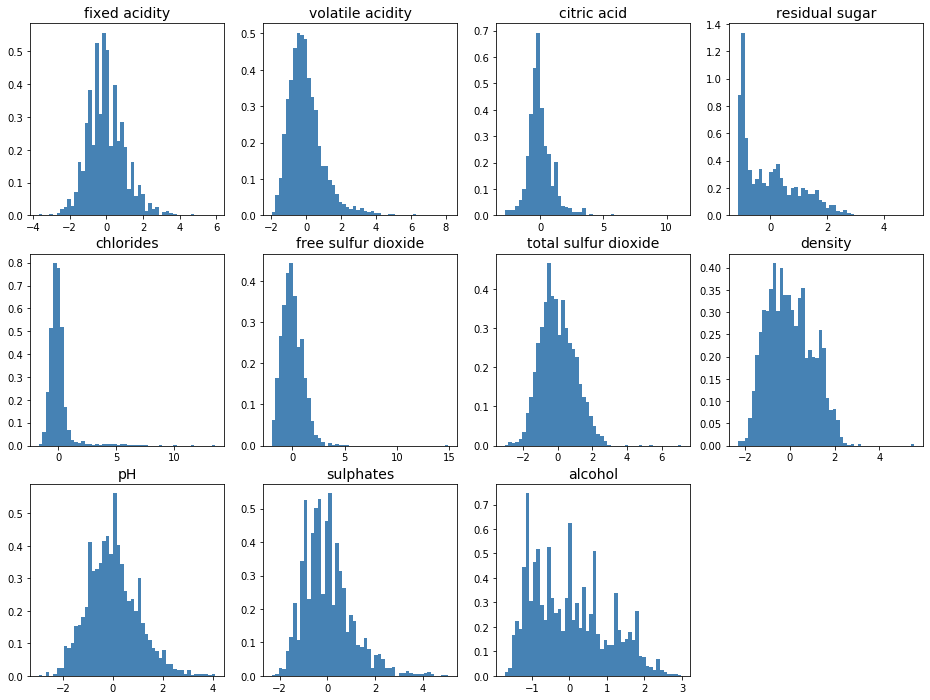

In [34]:
# Representation
fig = plt.figure(figsize=(16,12))

for feat_idx in range(X_train_std.shape[1]):
    ax = fig.add_subplot(3,4, (feat_idx+1))
    h = ax.hist(X_train_std[:, feat_idx], bins=50, color='steelblue', density=True, edgecolor='none')
    ax.set_title(data.columns[feat_idx], fontsize=14)

### 3. Evaluation des performances avec la fonction originale GridSearchCV ()

In [35]:
from sklearn import neighbors, metrics

# Fixer les valeurs des hyperparamètres à tester
param_grid = {'n_neighbors':[3, 5, 7, 9, 11, 13, 15]}

# Choisir un score à optimiser, ici l'accuracy (proportion de prédictions correctes)
score = 'accuracy'

# Créer un classifieur kNN avec recherche d'hyperparamètre par validation croisée
clf = model_selection.GridSearchCV(
    neighbors.KNeighborsClassifier(), # un classifieur kNN
    param_grid,     # hyperparamètres à tester
    cv=5,           # nombre de folds de validation croisée
    scoring=score   # score à optimiser
)

# Optimiser ce classifieur sur le jeu d'entraînement
clf.fit(X_train_std, y_train)

# Afficher le(s) hyperparamètre(s) optimaux
print("Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement selon la GridSearchCV originale:")
print(clf.best_params_)

# Afficher les performances correspondantes
print("Résultats de la validation croisée :")
for mean, std, params in zip(
        clf.cv_results_['mean_test_score'], # score moyen
        clf.cv_results_['std_test_score'],  # écart-type du score
        clf.cv_results_['params']           # valeur de l'hyperparamètre
    ):

    print("{} = {:.3f} (+/-{:.03f}) for {}".format(
        score,
        mean,
        std*2,
        params
    ) )

Meilleur(s) hyperparamètre(s) sur le jeu d'entraînement selon la GridSearchCV originale:
{'n_neighbors': 5}
Résultats de la validation croisée :
accuracy = 0.757 (+/-0.032) for {'n_neighbors': 3}
accuracy = 0.765 (+/-0.019) for {'n_neighbors': 5}
accuracy = 0.756 (+/-0.031) for {'n_neighbors': 7}
accuracy = 0.764 (+/-0.023) for {'n_neighbors': 9}
accuracy = 0.761 (+/-0.018) for {'n_neighbors': 11}
accuracy = 0.760 (+/-0.022) for {'n_neighbors': 13}
accuracy = 0.758 (+/-0.016) for {'n_neighbors': 15}


In [37]:
y_pred = clf.predict(X_test_std)
print("\nEt la performance finale sur le jeu de test est Perfom1 = {:.3f}".format(metrics.accuracy_score(y_test, y_pred)))


Et la performance finale sur le jeu de test est Perfom1 = 0.750


------------------------------------------

### 4. Implémentation de my_grid_seachCV

Nous allons maintenant implémenter notre propre fonction de Validation croisée appelée <b>my_grid_searchCV()</b> pour faire une validation croisée du paramètre k d’un kNN (le nombre de plus proches voisins) sur le jeu d’entraînement :

In [99]:
# implementation de la fonction my_grid_searchCV

def my_grid_searchCV(hyperparams, cv, score='accuracy'):
    
    """Cette fonction execute une validation croisée sur différents k-NN
    entrées : cv nombre de folds, hyperparams liste des hyperparamètres k-NN à tester
    sorties : Les performances des modèles testées"""
    
    k_optimal = 0
    mean_scores = [] # pour stocker les scores moyens des k en vue d'optenir le k optimal
    
    skf = StratifiedKFold(n_splits=cv, random_state=None)
    
    # pour chaque hyperparams, on fait la validation croisée (boucle d'execution du modèle pour chaque fold)
    for index, valeur_k in enumerate(hyperparams):
        
        accuracies = []
        
        # construction du k-nn correspondant
        knn = neighbors.KNeighborsClassifier(valeur_k)       
        
        for train, test in skf.split(X_train_std, y_train): # Attention : train, test sont des index
            
            #print (X_train_std[train].shape, X_train_std[test].shape)
            knn.fit(X_train_std[train], y_train[train])
            predict = knn.predict(X_train_std[test])

            accuracies.append(knn.score(X_train_std[test], y_train[test]))
        
        score_moyen = np.mean(accuracies) #score moyen des folds pour l'hyper-parametre
        std_score = np.std(accuracies) # ecart-type (deviation...) pour l'hyper-parametre
        mean_scores.append(score_moyen)
        print("{} = {:.3f} (+/-{:.03f}) for {}".format(score, score_moyen, std_score*2, valeur_k))
        
        if (score_moyen==max(mean_scores)):
            k_optimal = valeur_k
        
    print("Le meilleur hyperparamètre sur le jeu d'entrainement selon my_grid_searchCV() est K = ", k_optimal)


In [100]:
# Appel de my_grid_searchCV
my_grid_searchCV([3, 5, 7, 9, 11, 13, 15], 5)

accuracy = 0.757 (+/-0.032) for 3
accuracy = 0.765 (+/-0.019) for 5
accuracy = 0.756 (+/-0.031) for 7
accuracy = 0.764 (+/-0.023) for 9
accuracy = 0.761 (+/-0.018) for 11
accuracy = 0.760 (+/-0.022) for 13
accuracy = 0.758 (+/-0.016) for 15
Le meilleur hyperparamètre sur le jeu d'entrainement selon my_grid_searchCV() est K =  5


<h3><font color='green'> SUCCÈS ! La fonction my_grid_searchCV obtient le même meilleur résultat que GridSearchCV</font></h3>
<h3><font color='blue'>Hyper-paramètre optimal est K = 5, correspondant à une accuracy de 0.765</font></h3>

<h4>Validation des résultats :</h4>

<p>
    <ul>
    <li>La fonction de validation croisée fournit le même résultat que la fonction scikit originale</li>
    <li>L'algorithme fonctionne</li>
    <li>L'évaluation a été correctement effectué</li>
    </ul>
</p>